<a href="https://colab.research.google.com/github/Bouncy0Knight/Exercise3/blob/main/CompModNervSys_exercise3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIOL 74.03 (SP23): Computational Modeling of the Nervous System 
## Exercise 3: Calculating membrane voltage and ionic currents in cells

### Exercise goals

1) Calculate resistances and capacitances within cellular geometries. 

2) Get comfortable writing code implementing mathematical equations and handling units

3) Use the Nernst equation to calculate ionic reversal potentials

4) Use the Goldman equation to calcualte resting membrane potentials

5) Analyze a simple RC circuit, a building block on the way to our first neuron model

Work through the code below, running each cell, adding code where required, and making sure you understand the output. When you see questions with ***Q:*** preceding them, write your responses in text cells. 

In [1]:
!git clone https://github.com/CompModNervSystem/CompModNervSys-NernstVm.git # downloads repository into our Google colab session's file system

Cloning into 'CompModNervSys-NernstVm'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 16 (delta 3), reused 16 (delta 3), pack-reused 0
Unpacking objects: 100% (16/16), 148.78 KiB | 6.20 MiB/s, done.


# Membrane resistance and capacitance

Suppose we have a spherical cell with diameter $d$ and a membrane with thickness $t$. Recall that resistance $R$ is given by $R = \rho L/A$, where $\rho$ is the resistivity of the medium, $L$ is the length over which current travels, and $A$ is the cross-sectional area. Write a function that computes the membrane resistance given a membrane resistivity $\rho_{m}$, which has units $\Omega \cdot cm$. Use this function to compute the membrane resistance of a cell in units of $M\Omega$ with a $10 \; \mu m$ diameter, membrane thickness of $3 \; nm$ (this refers to the insulating part of the lipid bilayer), and resistivity of $5 \; G \Omega cm$ ($1\cdot10^{9} \Omega cm$) and print the output. 

For a refresher on converting between metric units, see the chart below:

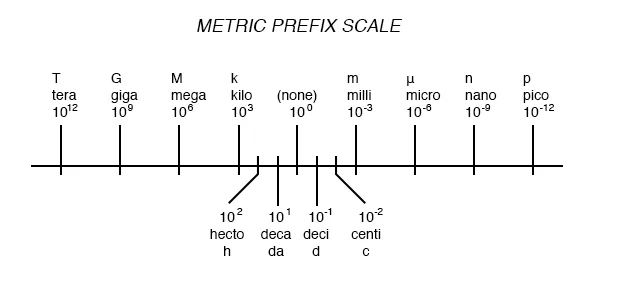

In [2]:
from IPython.display import Image
import math
Image('CompModNervSys-NernstVm/resources/metric-prefix-scale.jpeg',width=500)

In [3]:
import numpy as np

def calcRsphericalCell(rho_m, d,t):
    R = rho_m*t/(4*3.14*(d/2)**2)
    return R*10**(-6)
    # your code goes here

rho_m =  5*10**(9) #resistivity - Ohm*cm 
d =  10*10**(-4)# diameter - cm
t =  3*10**(-7) # thickness - cm 

R = calcRsphericalCell(rho_m,d,t)
print('Resistance = {:.1f} MOhms'.format(R))

Resistance = 477.7 MOhms


***Q1***: How would you convert this to the membrane's conductance?

I would take the inverse -- that is, raise the Resistance to the -1 power

Now, write a similar function to calculate the membrane's capacitance. Recall the equation for capacitance of parallel plates is $C = \epsilon A/L$, where $\epsilon$ is the dielectric constant of the medium's between the plates, $A$ is the surface area, and $L$ is the distance between the plates. Use this function to compute the membrane capacitance of the same cell in units of $pF$ with $\epsilon = 0.3 pF/cm$ and print the output.

In [4]:
def calcCsphericalCell(eps_m, d,t):
    # your code goes here
    C = eps_m/t * (4*math.pi*(d/2)**2)
    return C*10**12

eps_m = 0.3e-12 # dielectric constant - F/cm
d =  10*10**(-4) # diameter - cm
t = 3*10**(-7) # thickness - cm 

C = calcCsphericalCell(eps_m,d,t)
print('Capacitance = {:.3f} pF'.format(C))



Capacitance = 3.142 pF


Since the membrane thickness is essentially constant across all excitable cells, it's often easier to refer to the *specific membrane resistance*, $R_{m}$, which is the resistance per unit area, and the *specific membrane capacitance*, $C_{m}$, which is the capacitance per unit area. $R_{m}$ is just the numerator of our resistance equation, so $\rho_{m}t$, and $C_{m}$ is obtained by combining the $\epsilon/t$ terms from the capacitance equation. 

***Q2***: What values of $R_{m}$, in units of $\Omega cm^{2}$, and $C_{m}$, in units of $\mu F/cm^{2}$, do we get using the values given above? How does the cell's total membrane resistance $R$ and capacitance $C$ scale with the diameter and surface area of the cell? 
These are the quantities you're more likely to see reported in experimental and modeling literature and that we'll be using in our models. 

In [5]:
#Q2 ANSWERED BELOW
Rm = rho_m*t
Cm = eps_m*10**6/t
print("Rm is equal to", rho_m*t, "Ohm cm squared")
print("Cm is equal to",  eps_m*10**6/t, "micro Farads per square cm")
print("The membrane resistance scales linearly with thickness, and membrane Capacitance scales inversely with thickness")


Rm is equal to 1500.0 Ohm cm squared
Cm is equal to 1.0 micro Farads per square cm
The membrane resistance scales linearly with thickness, and membrane Capacitance scales inversely with thickness


Now, write new functions calculating the membrane resistance an capacitance, based on your functions above that instead take as input $R_{m}$ and $C_{m}$. Check that you get the same output as above. Be careful about units!

In [6]:
# your new functions go here
def calcRMembrane(Rm, d):
  R  = Rm/(4*math.pi*(d/2)**2)
  return R*10**-6

def calcCMembrane(Cm, d):
  C = Cm * (4*math.pi*(d/2)**2)
  return C*10**6

# Call your functions and return R and C here
R = calcRMembrane(Rm, d)
C = calcCMembrane(Cm,d)
print('Resistance = {:.1f} MOhms'.format(R))

print('Capacitance = {:.3f} pF'.format(C))

Resistance = 477.5 MOhms
Capacitance = 3.142 pF


# Calculating the Nernst potential

Now let's calculate the Nernst equilibrium potential for some typical ion concentrations in mammalian neurons. Recall the Nernst equation is:

$V_{m}^{eq} = RT/ZF \ln([C]_e/[C]_i)$

Where $R$ is the gas constant, $8.314 J/K \cdot mole$, $T$ is temperature in $K$ (Kelvin), $Z$ is the ion's valence (don't forget the sign!), and $F$ is Faraday's constant, $96,485.3 C/mole$. $[C]_e$ and $[C]_i$ are the extracellular and intracellular concentrations. 

***Q3***: Do the units of concentration matter in this equation?

No; since the extracellular concentration is divided by the intracellular concentration, the units will cancel. 

| Ion            | Intracellular [mM] | Extracellular [mM] |
| -------------- | ------------------ | ------------------ |
| Potassium (K+) | 140 | 5 |
| Sodium (Na+) | 15 | 145 |
| Chloride (Cl-) | 5 | 110 |


Write a single function that outputs the Nernst potential for a given ion. Then, using your function and the concentrations above, print the Nernst potentials (in $mV$) for potassium, sodium, and chloride for a neuron at body temperature ($37^{\circ} C$). Just use 1 decimal place for outputting these values. 

In [7]:
def calcNernstIon(Z,Ci,Ce, Temp = 37):
    # your code goes here
    Temp = Temp + 273.15 #converting from C to K
    Vm = (8.314*Temp)/(Z*96485.2) * math.log(Ce/Ci,math.e)
    return Vm*10**3
Ek = calcNernstIon(1,140,5)
Ena = calcNernstIon(1,15,145)
Ecl = calcNernstIon(-1,5,110)

print('Ek = {:.1f} mV, Ena = {:.1f} mV, Ecl = {:.1f} mV'.format(Ek,Ena,Ecl))

Ek = -89.1 mV, Ena = 60.6 mV, Ecl = -82.6 mV


This gives us the reversal potential for individual ions, but we know from the Goldman equation that the actual rest potential is a function of the ion concentrations *and* their permeabilities in the membrane. The Goldman equation is given by:

$V_{m}^{eq} = \frac{RT}{ZF}\ln \left( \frac{P_{K}[K]e + P_{Na}[Na]e + P_{Cl}[Cl]i}{P_{K}[K]i + P_{Na}[Na]i + P_{Cl}[Cl]e} \right)$

Write a function that uses the Goldman equation to compute the resting potential given a set of K, Na, and Cl- permeabilities and concentrations. Use it to calculate the resting potential given relative resting permeabilities $P_{K}:P_{Na}:P_{Cl}$ of $1:0.05:0.45$ at body temperature and print the output in $mV$.

In [8]:
def calcVmGoldman(Pk,Pna,Pcl,Kext,Kinternal,NaInt,NaExt,ClInt,ClExt):
    # your code goes here
    const = (8.314*(37+273.15))/(1*96485.3)
    Vm = const * math.log((Pk*Kext + Pna*NaExt + Pcl *ClInt)/(Pk*Kinternal + Pna*NaInt + Pcl * ClExt))
    return Vm*10**3

Vm = calcVmGoldman(1,0.05,0.45,5,140,15,145,5,110)
print('Resting Vm = {:.1f} mV'.format(Vm))

Resting Vm = -68.8 mV


# Now, suppose we were doing an experiment where we had some neurons in a dish and can control the concentration of ions in the extracellular solution. When mimicking the normal extracellular environment of neurons, this solution is sometimes called artificial cerebrospinal fluid (aCSF). It also includes other important things like buffers and energy sources (glucose) so our neurons are happy outside of the brain where they usually belong, but for our purposes, the ions are what matters. 

We want to see how resting membrane potential varies with extracellular potassium concentration, which we control in the aCSF. We can measure the intracellular voltage of the cell with a special electrode made out of a glass micropipette pulled to a fine tip less than 1 $\mu m$ in diameter containing an electrolyte solution mimicking the cytosol and a wire that connects to a fancy voltmeter that amplifies small voltage or current signals. We'll talk more about this technique, called patch clamp electrophysiology, in class. 

Assuming your function worked, you can tell that the resting membrane potential is closest to the Nernst potential for potassium ($E_{k}$). If we did an experiment varying the extracellular potassium concentration and measuring resting membrane potential, what would we see? Use `matplotlib` (or your preferred plotting package) to plot the resting membrane potential vs. extracellular potassium concentration. Assume all the other intracellular and extracellular concentrations are the same as before and we heated up our neurons to body temperature. Use a log-scale on the x-axis. (Hint: your output should look like Figure 2.7 from Ch.2 of Purves, Neuroscience, the assigned reading).

(-80.0, 10.0)

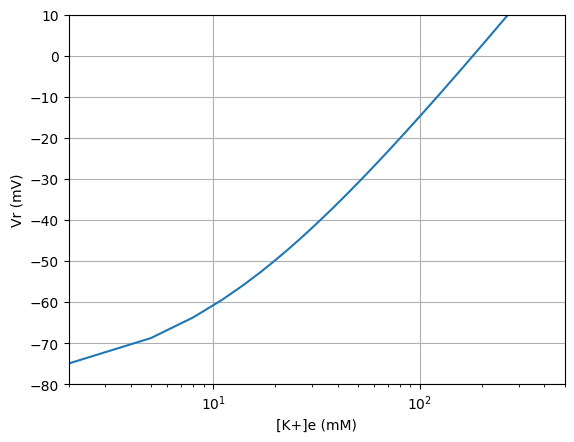

In [9]:
import matplotlib.pyplot as plt

Ce_k_vec = np.arange(2,500,3)# fill in arguments) # vector of concentrations in mM
Vm_vec = []
for concentration in Ce_k_vec:
  Vm_vec.append(calcVmGoldman(1,0.05,0.45,concentration,140,15,145,5,110))
# your code goes here  # vector of resting membrane potentials (mV)
fig = plt.figure()
ax = fig.add_subplot(111)
# Plot statement goes here
ax.plot(Ce_k_vec,Vm_vec)
#
ax.grid(visible=True)
ax.set_xscale('log')
ax.set_xlabel('[K+]e (mM)')
ax.set_ylabel('Vr (mV)')
ax.set_xlim([2, 500])
ax.set_ylim([-80,10])

Let's say we wanted to do an experiment where we raised the resting membrane potential by $10 mV$ from the value you calculated earlier. What concentration of K+ should we use in the extracellular solution? 

You could do some math to work this out, or if you're lazy (like me), write some code to work it out for you. One way would be to just plug in a vector of finely sampled $[K+]_{e}$ (guesses) to the Goldman equation function you wrote and extract the resting membrane potential closest to our desired potential. Write a function below that does this using either this method or a method of your choosing. If you get stuck here, you can just use the "guess and check" method with your function and move on. 


In [10]:
Vmemb = calcVmGoldman(1,0.05,0.45,11.56,140,15,145,5,110)
print(Vmemb)

print("Using a concentration of 11.56 gives you a value that roughly corresponds to a resting Vm of -58.8mV, which is 10 mV larger than the resting membrane potential of -68.8 mV calculated earlier. ")

-58.82114750099465
Using a concentration of 11.56 gives you a value that roughly corresponds to a resting Vm of -58.8mV, which is 10 mV larger than the resting membrane potential of -68.8 mV calculated earlier. 


# First look at the RC circuit model

Let's start playing with the most basic circuit model of a cell membrane, an RC circuit, shown below. In this case, we're modeling the membrane conductance as *passive*, i.e., ignoring the presence of nonlinear voltage gated ion channels. This turns out to be a decent model of neuronal membranes at voltages near equilibrium, since the nonlinear currents are still small. The circuit is composed of the membrane capacitance $C_{m}$ in parallel with a resistor $R$ representing an ionic conductance ($g=1/R$) with a reversal potential $E_{rev}$. This is sometimes referred to as the *leak* conductance and is simply the total conductance of the membrane's ion channels at rest lumped together and treated as passive (non-voltage dependent). Since we only have a single leak conductance, this is equivalent to the membrane resistance, $R_{m}$, which we'll use in the model equations below. 

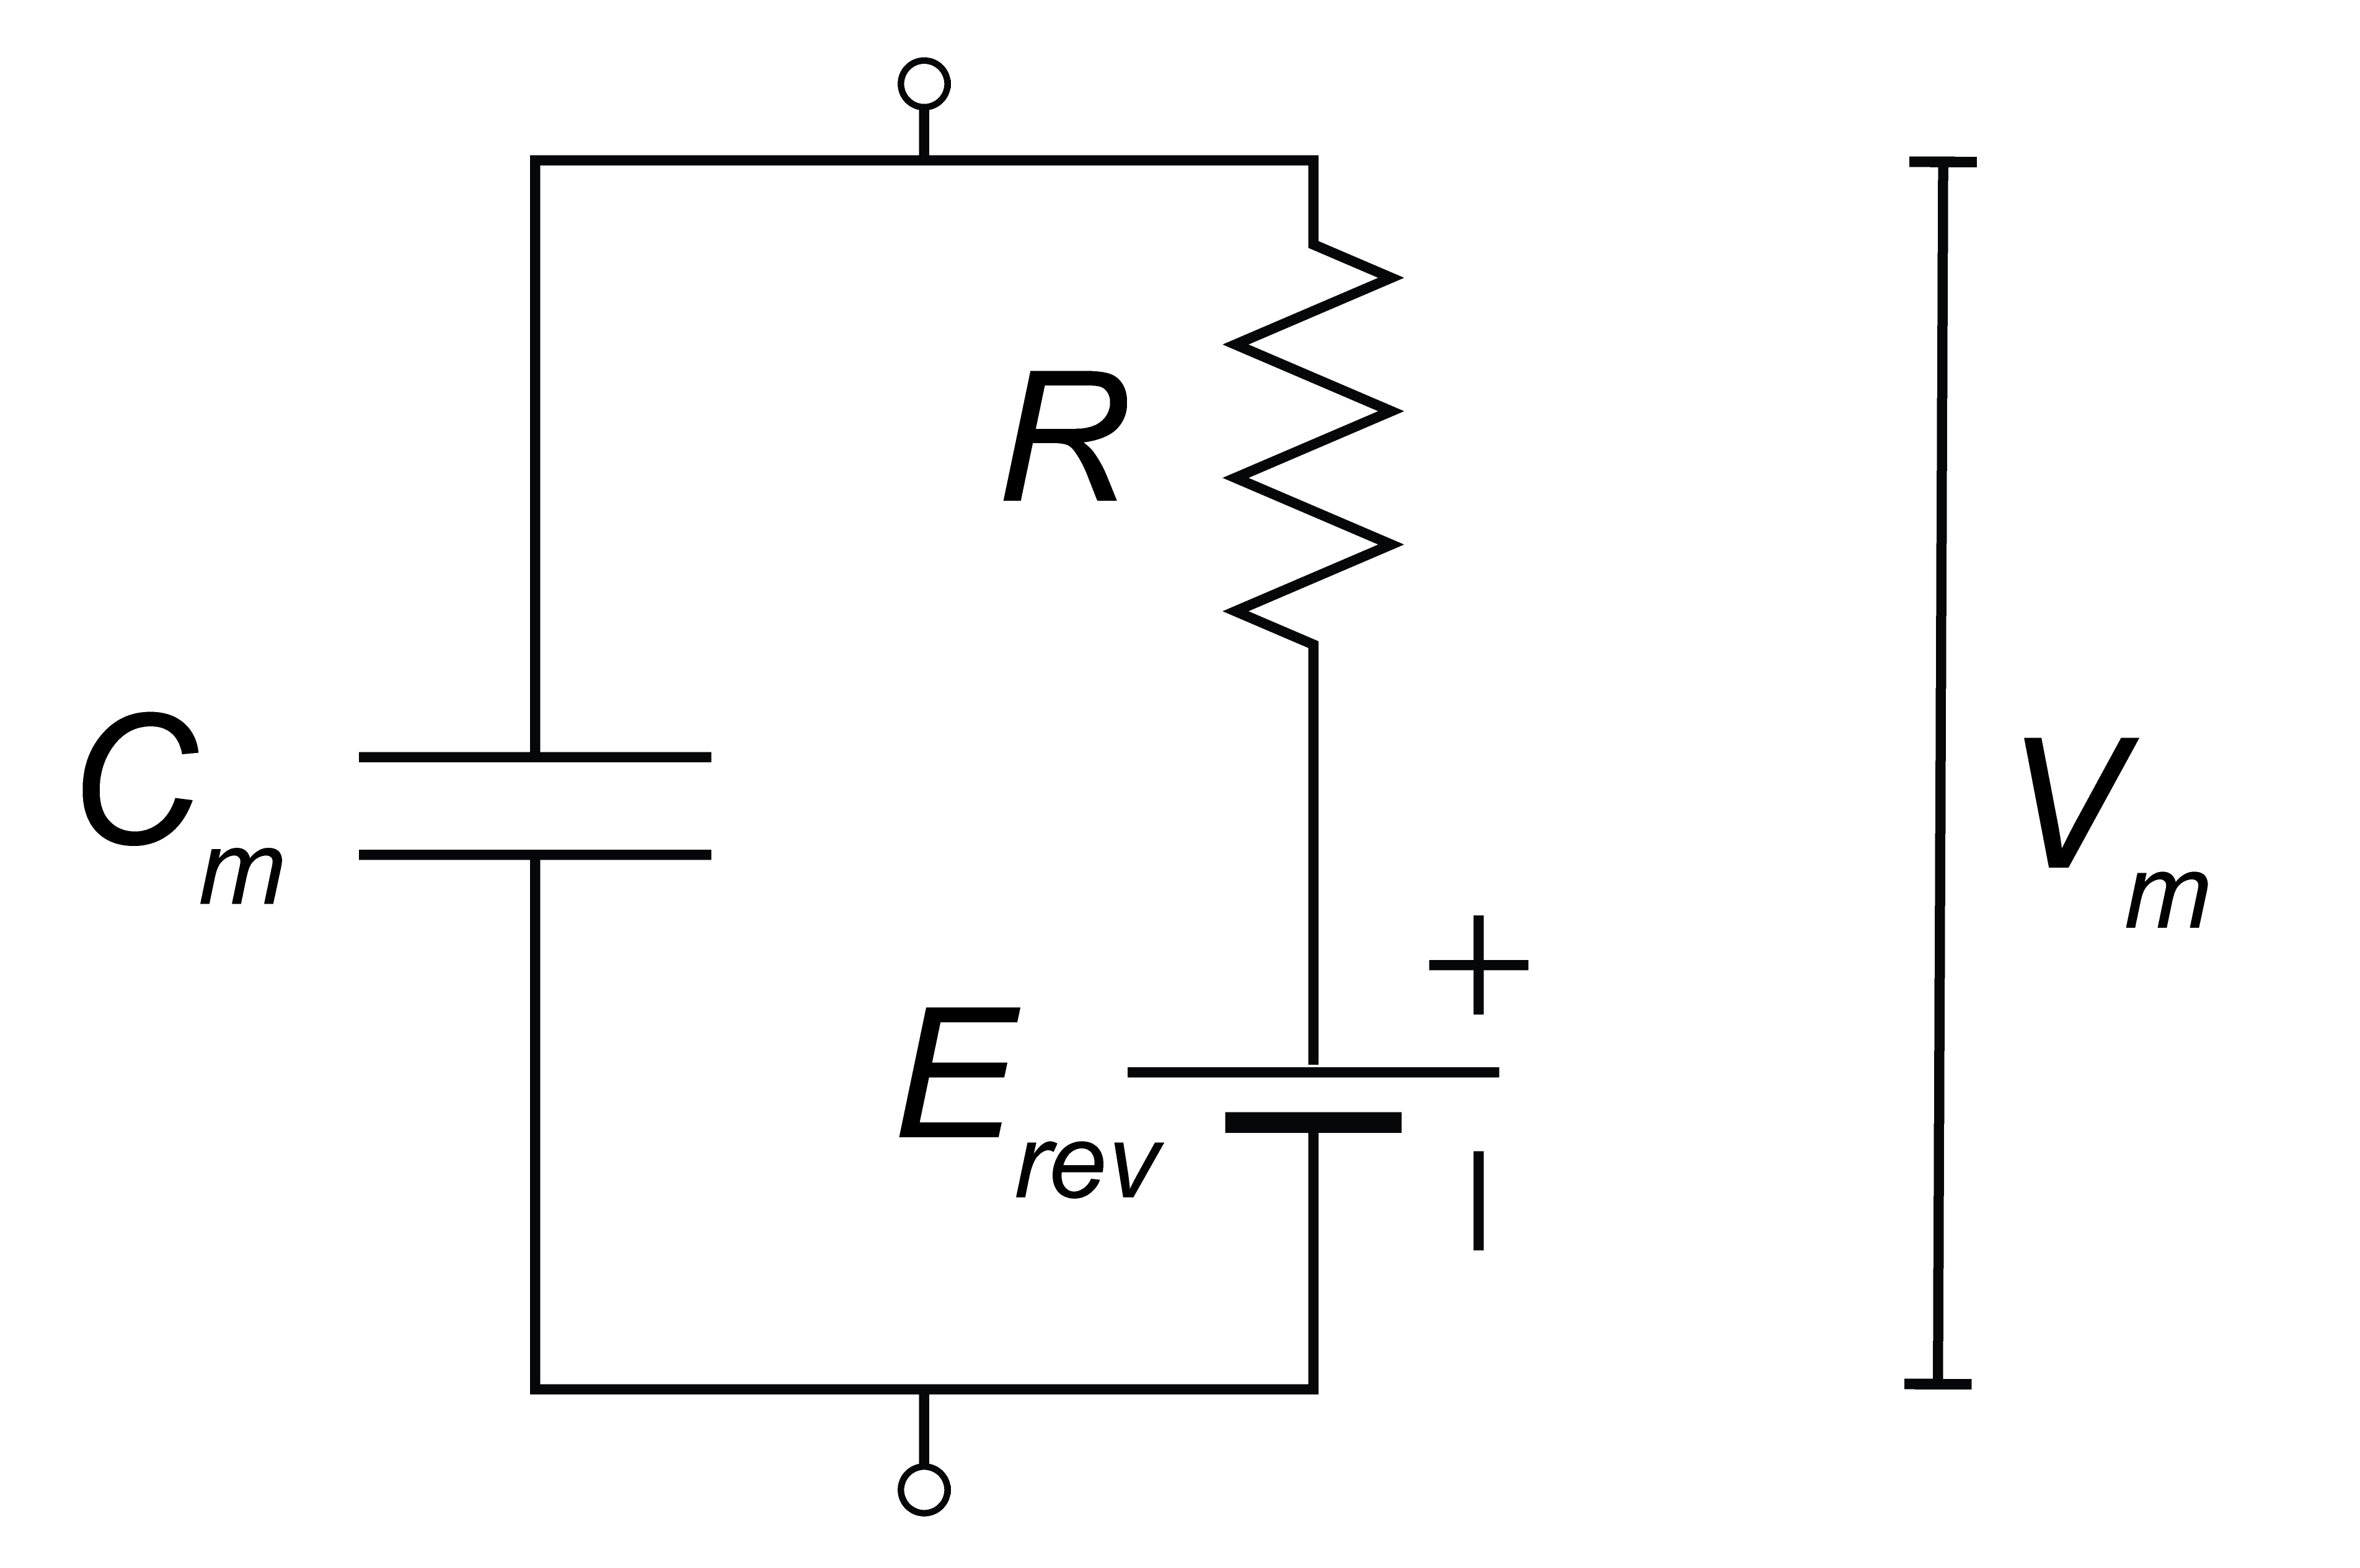

In [11]:
Image('CompModNervSys-NernstVm/resources/RC_circuit.png',width=250)

There's only one path for current to flow, so we know the capacitive current is always equal and opposite to the ionic current:

$I_{C}(t) = -I_{ion}(t)$.

Recall, the equation for current in a capacitor is $I_{C} = CdV/dt$ and the equation for current through an ion channel with a reversal potential is just the modified version of Ohm's law we introduced in class, $I_{ion} = (1/R)(V_{m} - E_{rev})$. Putting these together we have:

$C_{m}\frac{dV_{m}(t)}{dt} = -(V_{m}(t) - E_{rev})/R_{m}$.

This is just a first order ordinary differential equation, which you may have seen before. I won't go through the derivation here, but here's the solution for $V_{m}$:

$V_{m}(t) = (V_{0}-E_{rev})e^{-t/R_{m}C_{m}} + E_{rev}$,

where $V_{0}$ is $V_{m}$ at $t=0$. 

***Q4***: First, what is $V_{m}$ at equilibrium ($t \rightarrow \infty$) and why?

It is E_rev. That is because as t approaches infinity, the term (V0−Erev)e−t/RmCm approaches 0. That leaves us with V(t) = 0 + E_rev. This means that V(t) approaches E_Rev as t approaches infinity. 

Now, let's use this model to simulate a simplified version of the experiment we conducted above where we wanted to increase the resting membrane potential by $10 mV$. Imagine we started with a reversal potential, in this case of our nonspecific leak conductance $E_{rev}$, of $-70 mV$, and we had a way of instantaneously changing the ion concentrations in the bath to generate our new reversal potential, $-60 mV$. 

Use the equation above and `numpy`/`matplotlib` to plot the voltage in $mV$ vs. time in $ms$. Use the $R$ and $C$ values we calculated at the beginning for a spherical cell for $R_{m}$ and $C_{m}$. Be careful about units!

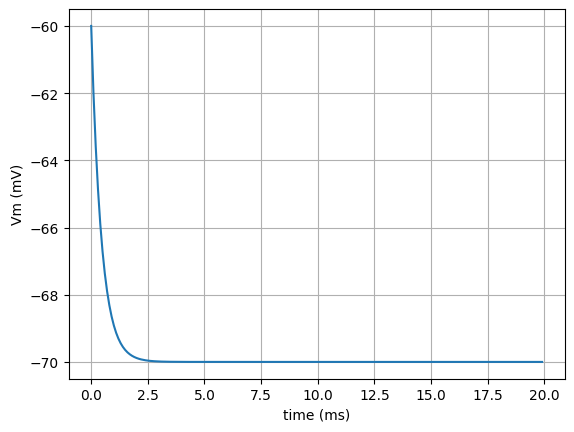

In [12]:
t = np.arange(0,.02,.0001)# your code goes here) # time in seconds
Vm = [] # your code goes here # membrane voltage in mV
E_rev = -70 #mV
V0 = -60 #mV
rho_m= 5*10**9
eps_m = 0.3e-6
d = 10e-4
th = 3e-7
Rm = rho_m*th
Cm = eps_m
e = math.e

Vm = (V0-E_rev)*e**(-t/(Rm*Cm)) + E_rev

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t*1e3,Vm)
ax.set_xlabel('time (ms)')
ax.set_ylabel('Vm (mV)')
ax.grid(visible=True)

As you may know from a differential equations course, the product $RC$ in this equation is also known as the time constant $\tau$. In our case, this is known as the *membrane time constant* and is given the special symbol $\tau_{m}$. It has units of time ($\Omega \cdot F = sec$, or $k\Omega \cdot \mu F = ms$). From inspecting the equation or your plot, you can see it's the time at which the voltage reaches 63.2% ($1-1/e$) of it's steady state value (or increases by 36.8%). In general, the time constant is a measure of how fast the membrane voltage can change in response to a stimulus (shorter times being faster). In our artificial situation, this was an instant change in bath concentrations, but later, this will be currents generated by synaptic inputs or electrical stimulation we apply. 

Below, try overlaying plots of the same manipulation if the time constant was doubled or halved. 

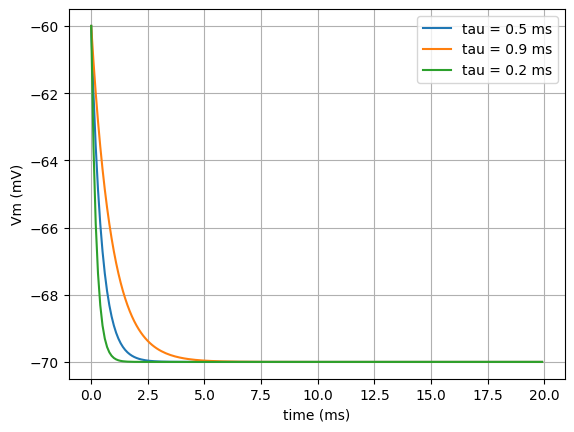

In [13]:
# Your code goes here
tau1 = Rm*Cm
tau2 = 2*tau1
tau3 = .5*tau1
Vm1 = (V0-E_rev)*e**(-t/tau1) + E_rev
Vm2 = (V0-E_rev)*e**(-t/tau2) + E_rev
Vm3 = (V0-E_rev)*e**(-t/tau3) + E_rev
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t*1e3,Vm1,label='tau = {:.1f} ms'.format(tau1*1e3))
ax.plot(t*1e3,Vm2,label='tau = {:.1f} ms'.format(tau2*1e3))
ax.plot(t*1e3,Vm3,label='tau = {:.1f} ms'.format(tau3*1e3))
ax.set_xlabel('time (ms)')
ax.set_ylabel('Vm (mV)')
ax.grid(visible=True)
ax.legend()

***Q5***: What physical variable could actually be changing to mediate this change in membrane time constant?

The resistance of the cell could be changing. This could be done by increasing or decreasing the number of ion channels present in the cell membrane 

Let's also take a look at the capacitive and ionic currents underlying the changes in $V_{m}$ for the first case we simulated. Plot the capacitive and ionic current as current densities in units of $pA/\mu m2$ by dividing each current by the total membrane surface area ($A = 4\pi(d/2)^2$, still using $d = 10 \; \mu m$). 

Since the capacitive current is given by $C_{m} dV_{m}/dt$, you could calculate the capacitive current numerically by taking the numerical *difference* of the voltage traces, but in this case, we can calculate the capacitive current analytically:

$I_{C}(t) = C_{m}dV_{m}/dt = C_{m}\frac{d}{dt}\left((V_{0}-E_{rev})\exp^{-t/R_{m}C_{m}} + E_{rev}\right)$

$I_{C}(t) = -\frac{V_{0} - E_{rev}}{R_{m}}\exp^{-t/R_{m}C_{m}}$

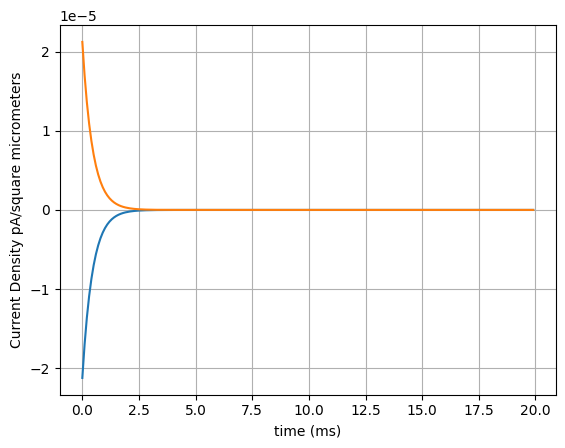

In [14]:
Ic = -((V0-E_rev)/Rm)*np.exp(-t/(Rm*Cm))
d = 10 #microMeters
IcDensity = Ic/(4*math.pi*(.5*d)**2)
Iionic = -1*Ic
IionicDensity = Iionic/(4*math.pi*(.5*d)**2)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t*1e3,IcDensity, label = 'Capacative Current Density')
ax.plot(t*1e3,IionicDensity,label = "Ionic Current Density")
ax.set_xlabel('time (ms)')
ax.set_ylabel('Current Density pA/square micrometers')
ax.grid(visible=True)


Finally, let's test a pretty major assumption we made when deciding to represent the Nernst potential as a fixed voltage source (battery). I mentioned in lecture that the ionic fluxes required to reach equilibrium, and more generally, that occur in the normal course of neural signaling don't significantly affect the bulk concentration of ions in the cell. Suppose we accomplished the $10 mV$ change by increasing the extracellular potassium concentration. 

***Q6***: In your own words, explain the sequence of events leading from the initial condition ($V_{m} = -70 mV$) to the final steady state condition ($V_{m} = -60 mV$). 

Assuming that -60mV is still below the threshold of excitation. One way that the cell could move from a -70mv to a -60 mv condition is that The cell pumps out more K ions from within the cell (and therefore decreases the K concentration inside the cell). This is caused by the increased activation of the Na-K pumps, and the cell reaches the steady state condition when the rate of K re-entering the cell matches the rate of K-exiting the cell via pumps. 


The excess charge from the movement of positive ions (let's use K+ for simplicity) is $Q=\Delta V_{m}C_{m}$. We can convert this from electrical charge in Coulombs to the amount of ion particles in moles $N$ using Faraday's constant, $N = Q/F$. Fill in the empty portions of the calculations below.

In [16]:
eps_m = .3e-6
t = 3e-7
d= 10e-4
C = calcCsphericalCell(eps_m,d,t) * 1e-24

deltaVm = .001 # V - change in membrane voltage
Q = deltaVm*C # C - charge built up on membrane 
F = 96485.3 # C/mol - faraday's constant
N = Q/F # number of charges moved
d = 10e-6 # m
Vol = (4/3)*np.pi*(d/2)**3 # m^3
Vol = Vol*1e3 # convert to L (1000 L per cubic meter)
Cki = 140e-3 # M - mols/liter - initial concentration
Ntot = Cki*Vol # mols K - initial
Cki2 = (Ntot-N)/Vol # M - mols/liter - final concentration

print('The intracellular concentration changed from {} mM to {} mM, {:f} %% change'.format(Cki*1e3,Cki2*1e3,100*(Cki2-Cki)/Cki))


The intracellular concentration changed from 140.0 mM to 139.9999999999378 mM, -0.000000 %% change


***Q7*** Is our assumption that ionic concentrations aren't affected by the ionic currents okay and why? Under what conditions is it a better or worse assumption, or in other words, can you think of scenarios where it would be more or less safe? 

It is a safe assumption -- our Cki is very similar to Cki2 and this means that the ionic concentrations aren't too affected by ionic currents. It might be less safe in situations where the number of moles of charge being moved is significant -- if our N gets too large, then it is possible to get some changes. It's more safe when the Number of moles of charge being moved is really small. 